In [ ]:
# add root folder to the path
import sys
sys.path.append('..')

In [2]:
import json
import os
from glob import glob
from time import time

import cv2
import numpy as np
import tensorflow as tf
from tqdm.notebook import tqdm

# import tensorrt as trt
from retinanet.dataset_utils.coco_parser import CocoParser
from retinanet.eval import COCOEvaluator
from retinanet.image_utils import imshow, read_image, visualize_detections_cv2

print('TensorFlow: ', tf.__version__)

TensorFlow:  2.7.0-dev20210731


In [3]:
# Starting from tensorflow==2.5.0, TensorRT ignores the conversion of combined_nms op if number of anchors is more than 4096
# Setting`TF_TRT_ALLOW_NMS_TOPK_OVERRIDE=1` will allow TensorRT to run top_k filtering with k=4096 prior to running NMS
# refer https://github.com/tensorflow/tensorflow/issues/46453 and https://github.com/tensorflow/tensorflow/pull/47698

os.environ['TF_TRT_ALLOW_NMS_TOPK_OVERRIDE'] = '1'

In [4]:
# Setup a virtual GPU to emulate resource constraints, this cell is optional
physical_devices = tf.config.list_physical_devices('GPU')

if physical_devices:
    tf.config.experimental.set_virtual_device_configuration(
        physical_devices[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2000)])
else:
    print('No GPU device found, running on CPU!')

In [5]:
# Load TensorRT plugins, if running with TensorRT optimized model
# trt.init_libnvinfer_plugins(None,'')

In [6]:
#  Load label mapping
with open('../coco_label_map.json', 'r') as f:
    label_map = json.load(f)

In [7]:
# Load `saved_model`
model = tf.saved_model.load(
    '../model_files/saved_models/mscoco-retinanet-resnet50-640x640-30x-64/')


prepare_image_fn = model.signatures['prepare_image']  # get concrete function for preprocessing images
serving_fn = model.signatures['serving_default']  # get concrete function for running the model

In [8]:
# Populate image paths

image_dir = '../val2017'
image_paths = sorted(glob(image_dir + '/*'))

print('Found {} images in {}'.format(len(image_paths), image_dir))

Found 5000 images in ../val2017


### Inference on a single image

Inference time: 7346.42 ms


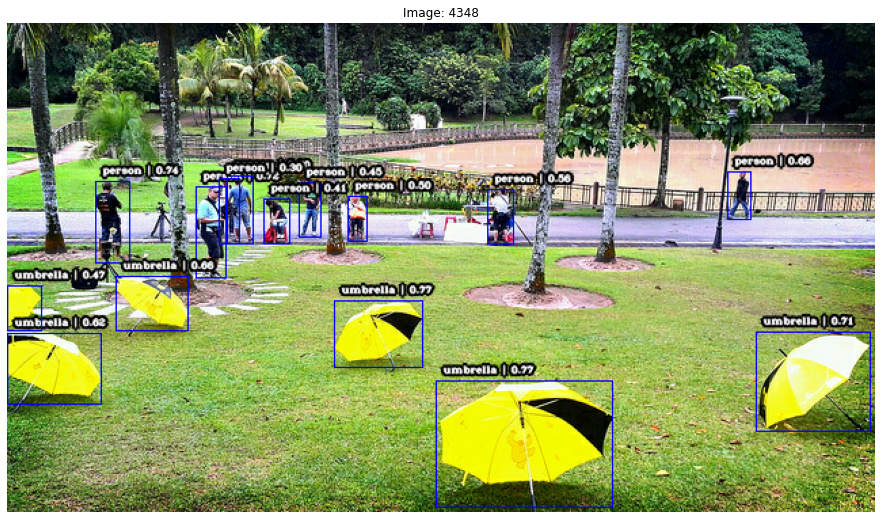

In [9]:
idx = 4348
image = read_image(image_paths[idx])
serving_input = prepare_image_fn(image=image,
                                 image_id=tf.constant([idx], dtype=tf.int32))
tik = time()
detections = serving_fn(**serving_input)
toc = time()

valid_detections = detections['valid_detections'][0].numpy()
boxes = detections['boxes'][0][:valid_detections].numpy()
classes = [
    label_map[str(idx)]
    for idx in detections['classes'][0][:valid_detections].numpy()
]
scores = detections['scores'][0][:valid_detections].numpy()

#  Visualize detections
imshow(
    visualize_detections_cv2(image,
                         boxes,
                         classes,
                         scores,
                         score_threshold=0.30,
                         save=False,
                         filename='image_{}.png'.format(idx)),
    title='Image: {}'.format(idx),
)

print('Inference time: {:.2f} ms'.format((toc - tik) * 1000))

### Inference on a folder of  images

In [ ]:
fps = 1.0
num_samples = len(image_paths)

for idx, image_path in enumerate(image_paths):
    t1 = time()
    image = read_image(image_path)
    t2 = time()
    serving_input = prepare_image_fn(
        image=image,
        image_id=tf.constant(idx, dtype=tf.int32))
    
    t3 = time()
    detections = serving_fn(**serving_input)
    t4 = time()
    
    fps = 0.95 * fps + 0.05 * (1 / (t4 - t3))
    eta = (num_samples - (idx + 1)) / fps

    print(
        '\rProcessed {}/{} images | ETA: {:.2f} secs | FPS(detection): {:.1f}/sec | forward_pass_with_nms: {:.3f} ms | image_reading: {:.3f} ms | image_preprocessing: {:.3f} ms'
        .format(idx + 1, len(image_paths), eta, fps, t4 - t3,
                t2 - t1, t3 - t2),
        end='')

Processed 3581/5000 images | ETA: 137.7 secs | FPS(detection): 10.3/sec | forward_pass_with_nms: 0.097 ms | image_reading: 0.003 ms | image_preprocessing: 0.002 mss

### Inference on a webcam stream

In [26]:
fps_detection = 1.0
fps_end_to_end = 1.0
video = cv2.VideoCapture(0 + cv2.CAP_DSHOW)

video.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
video.set(cv2.CAP_PROP_FRAME_HEIGHT, 640)
# video.set(cv2.CAP_PROP_FPS, 30)
video.set(cv2.CAP_PROP_FOURCC, cv2.VideoWriter_fourcc(*'MJPG'))

while (True):
    t1 = time()
    ret, frame = video.read()
    t2 = time()

    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
    serving_input = prepare_image_fn(image=np.float32(frame),
                                     image_id=tf.constant(idx, dtype=tf.int32))

    t3 = time()
    detections = serving_fn(**serving_input)
    t4 = time()

    fps_detection = 0.95 * fps_detection + 0.05 * (1 / (t4 - t3))
    fps_end_to_end = 0.95 * fps_end_to_end + 0.05 * (1 / (t4 - t1))

    valid_detections = detections['valid_detections'][0].numpy()
    boxes = detections['boxes'][0][:valid_detections].numpy()
    classes = [
        label_map[str(idx)]
        for idx in detections['classes'][0][:valid_detections].numpy()
    ]
    scores = detections['scores'][0][:valid_detections].numpy()

    frame = visualize_detections_cv2(frame,
                                     boxes,
                                     classes,
                                     scores,
                                     score_threshold=0.35,
                                     save=False)

    info = 'FPS(detection): {:.1f}/sec | FPS(end_to_end): {:.1f}/sec | forward_pass_with_nms: {:.3f} ms | image_reading: {:.3f} ms | image_preprocessing: {:.3f} ms'.format(
        fps_detection, fps_end_to_end, t4 - t3, t2 - t1, t3 - t2)

    frame = cv2.putText(frame,
                        info, [25, 25],
                        cv2.FONT_HERSHEY_COMPLEX_SMALL,
                        .6, [0, 0, 255],
                        1,
                        lineType=cv2.LINE_AA)

    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
    cv2.imshow('frame', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

video.release()
cv2.destroyAllWindows()

In [24]:
frame.shape

(720, 1280, 3)

In [ ]:
3840 